# Google Analytics Customer Revenue Prediction

1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your system

## 1. Framstille problemstillingen og se på det store bilde

80/20-regelen har vist seg sann for mange bedrifter - bare en liten prosentandel av kundene produserer det meste av inntektene. Derfor utfordres markedsføringsteam til å foreta hensiktsmessige investeringer i salgsfremmende strategier.

I denne notebooken skal vi analysere et Google Merchandise Store-datasett (også kjent som GStore), for å forutsi omsetning per kunde. Vi har fått tildelt et datasett som inneholder informasjon om hver bruker som har besøkt nettsiden.

Her vil vi se på om det er en sammenheng mellom informasjonen og handlingene til kunden, og bruke dette til å kunne estimere hvor stor omsetning GStore vil få fra en enkelt kunde.

Prosjektet baserer seg på den pågående konkurransen på Kaggle: https://www.kaggle.com/c/ga-customer-revenue-prediction. Dette betyr at vi har fått et forhåndsdefinert datasett og testsett. 

Her er formelen som blir brukt for submission score:
![Scoremetode](https://i.imgur.com/2jsWyx4.png)

Der y-hatt er den naturlige logaritmen av den predictede inntekten, mens y er den naturlige logaritmen av intektssummen pluss en.

Under ligger funksjonsbeskrivelser for hvert objekt i datasettet:

*   channelGrouping - Kanalen brukeren kom til GStore gjennom.
*   date - Datoen brukeren besøkte GStore.
*   device - Spesifikasjonene for enheten som brukeren brukte for å gå inn på GStore.
* fullVisitorId - En unik identifikator for hver bruker av Google Merchandise Store.
* geoNetwork - Denne delen inneholder informasjon om brukerens geografi.
* sessionId - En unik identifikator for dette besøket i butikken.
* socialEngagementType - Engagement type, enten "Socially Engaged" eller "Not Socially Engaged".
* totals - Denne delen inneholder samlede verdier fra hele sesjonen.
* trafficSource - Denne delen inneholder informasjon om trafikkilden som sesjonen kommer fra.
* visitId - En identifikator for denne sesjonen. Dette er en del av verdien som vanligvis lagres som en _utmb-informasjonskapsel. Dette er bare unikt for brukeren. For en helt unik ID, bør du bruke en kombinasjon av fullVisitorId og visitId.
* visitNumber - Sesjonsnummeret for denne brukeren. Hvis dette er den første sesjonen, er dette satt til 1.
* visitStartTime - Tidsstempelet (uttrykt som POSIX-tid).



### 1.5 Setup

Implementering og installering av alle biblotekene vi vil få bruk for i notebooken:


In [0]:
!pip install lightgbm
!pip install pandas --upgrade
!pip install sklearn --upgrade
!pip install seaborn --upgrade
!pip install xgboost

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

import xgboost as xgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
import datetime

from google.colab import drive

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error



    100% |████████████████████████████████| 1.2MB 15.7MB/s 
    100% |████████████████████████████████| 8.9MB 4.2MB/s 
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
    100% |████████████████████████████████| 215kB 22.8MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


## 2. Importering av data

Ettersom dette var en gruppeoppgave på 3 personer fant vi ut at det var lettere og bedre å hente datasettet inviduelt fra Google Drive. På denne måten forsikret vi at alle jobbet med samme datasett og at dataen blir importert på samme måte.

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Funksjon under importerer datasettet fra Google Drive. Dataen vi henter er lagret som JSON-objekter og trenger derfor å bli konvertert til et pandas-dataframe for at det skal være mulig for oss å bruke det i modellene vi har satt opp. Funksjonen flater også ut objektene.

In [0]:
def load_df(csv_path='drive/My Drive/input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(list(df[column]))
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

Laster inn datasettene ved å bruke metoden vi definerte over, %time tar tiden på dette:


In [0]:
%%time
train_df = load_df()
test_df = load_df("drive/My Drive/input/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 2min 45s, sys: 12.5 s, total: 2min 58s
Wall time: 3min 15s


For å forsikre oss om at datasettet ble importert på rett måte går vi igjennom de 5 første radene til datasettet:

In [0]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

## 3. Utforske dataen man har fått tildelt og se unike mønstre

Det vi starter med er å se nærmere på selve objektet vi prøver å estimere resultatet til. Det man fort ser er at det ikke er så mange som faktisk bruker penger på butikken (20% av besøkende). Dette beviser hvorfor vi prøver å finne ut hvor mye neste bruker kommer til å bruke slik at Google kan vurdere å bruke mer energi på dem som faktisk bruker penger på Google-utstyr.

Grafen under bekrefter 80/20-regelen:

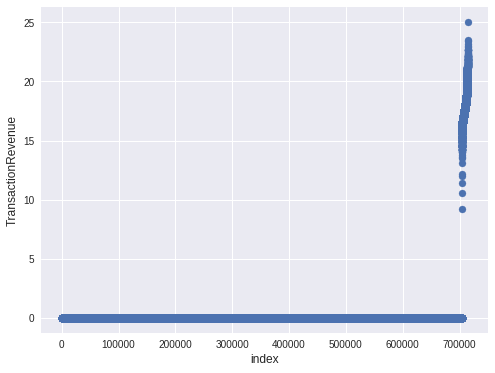

In [0]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [0]:
train_df["date"].describe()

count    9.036530e+05
mean     2.016589e+07
std      4.697698e+03
min      2.016080e+07
25%      2.016103e+07
50%      2.017011e+07
75%      2.017042e+07
max      2.017080e+07
Name: date, dtype: float64

Ved hjelp av funksjonen over kan vi se at date inneholder float-objekter som vi ikke kan bruke videre i koden for å skrive ut grafer og evaluere datasettet. 

Vi må derfor konvertere date til et datetime-objekt. For å gjøre dette bruker vi en lambda-funksjon på datoene for å separere:

In [0]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

Under kan vi se at de nye dato-objektet faktisk ble datoer. Ved hjelp av dette kan vi bruke denne informasjonen til å se nærmere på når det ble brukt mest penger.

In [0]:
train_df["date"].describe()

count         903653
unique           366
top       2016-11-28
freq            4807
Name: date, dtype: object

Under har vi en graf som viser den daglige omsetningen over tid. Man ser at grafen har kraftige høydepunkter til noen satte tider. Med denne informasjonen må vi passe på at modellen ikke blir påvirket for kraftig av disse og overfitter ny data.

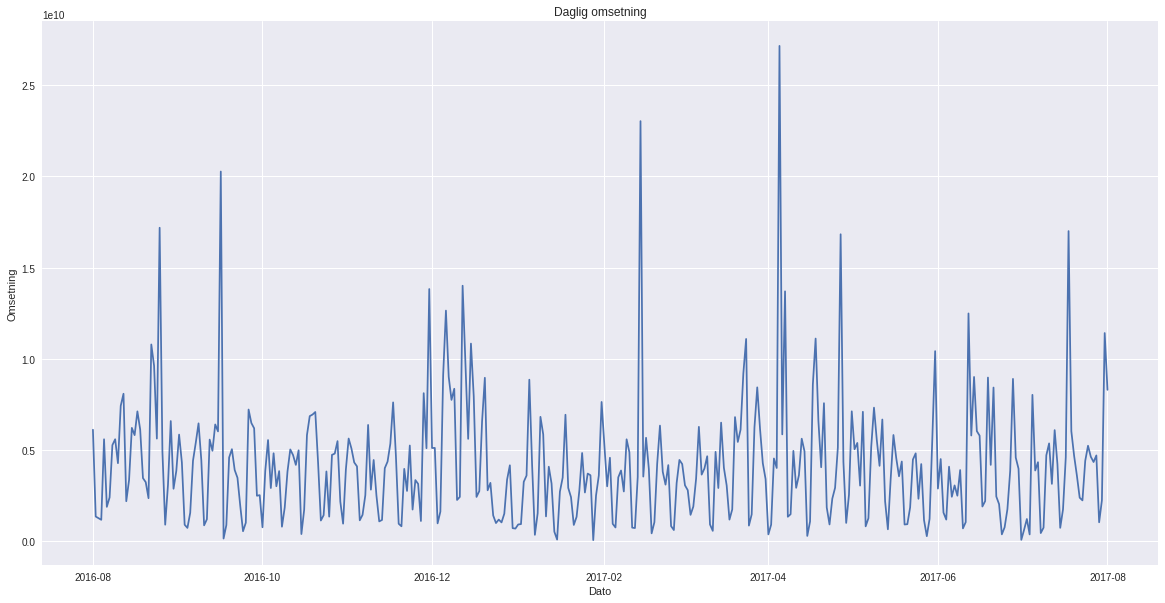

In [0]:
revenue_datetime_df = train_df[["totals.transactionRevenue" , "date"]].dropna()

daily_revenue_df = revenue_datetime_df.groupby(by=["date"],axis = 0 ).sum()
#import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Daglig omsetning")
axes.set_ylabel("Omsetning")
axes.set_xlabel("Dato")
axes.plot(daily_revenue_df["totals.transactionRevenue"])

Det neste vi gjør er å se nærmere på hvilke nettleser, opperativsystem, og enhet hver bruker benytter seg av. 

In [0]:
tmp_device_df = train_df[["device.browser","device.operatingSystem","device.deviceCategory","device.isMobile"]]

Vi tar en titt på de 5 første radene og ser om vi har fått den informasjonen vi ønsker.

In [0]:
tmp_device_df.head()

,device.browser,device.operatingSystem,device.deviceCategory,device.isMobile
0,Chrome,Windows,desktop,False
1,Firefox,Macintosh,desktop,False
2,Chrome,Windows,desktop,False
3,UC Browser,Linux,desktop,False
4,Chrome,Android,mobile,True


Det neste vi gjør er å se nærmere på hvor mye forskjellig data vi faktisk jobber med. 

In [0]:
tmp_device_df.describe()

,device.browser,device.operatingSystem,device.deviceCategory,device.isMobile
count,903653,903653,903653,903653
unique,54,20,3,2
top,Chrome,Windows,desktop,False
freq,620364,350072,664479,664530


Det kan også være nyttig å visualisere denne informasjonen. Ved hjelp av dette ser vi fort at brukere som bruker chrome, windows og desktop er den største andelen av brukere på nettsiden. Man kan derfor kanskje se at det er mer sannsynlig at en andel av disse brukerene vil stå for større omsetning enn andre.

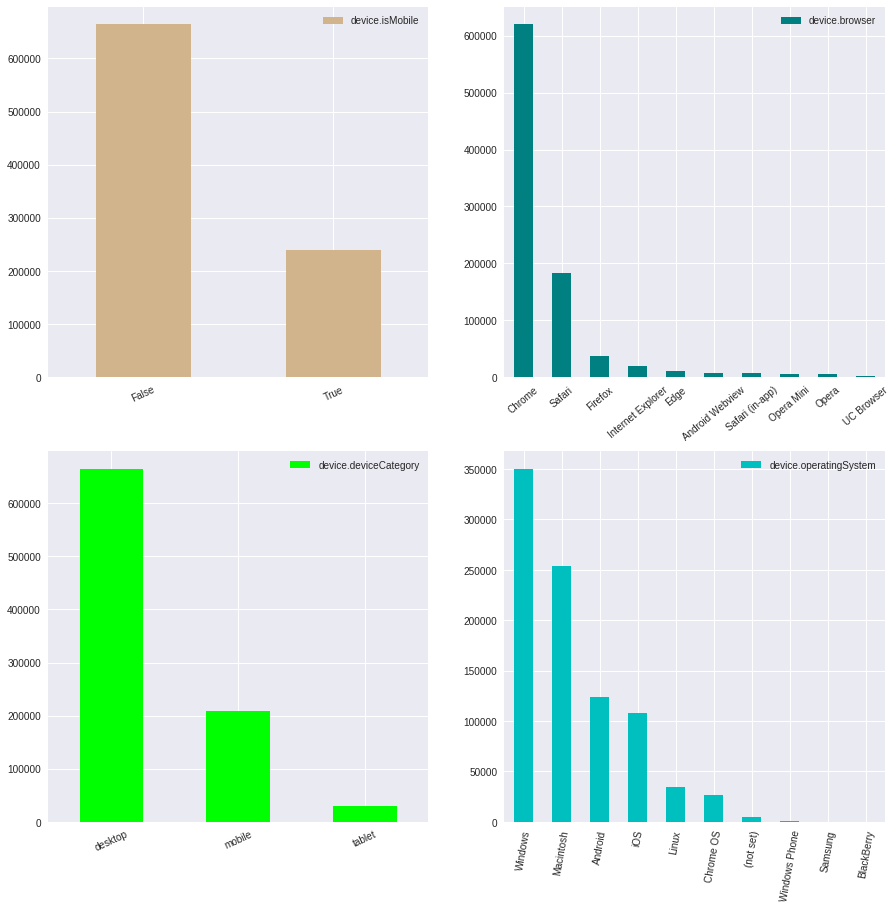

In [0]:
fig, axes = plt.subplots(2,2,figsize=(15,15))
tmp_device_df["device.isMobile"].value_counts().plot(kind="bar",ax=axes[0][0],rot=25,legend="isMobile",color='tan')
tmp_device_df["device.browser"].value_counts().head(10).plot(kind="bar",ax=axes[0][1],rot=40,legend="browser",color='teal')
tmp_device_df["device.deviceCategory"].value_counts().head(10).plot(kind="bar",ax=axes[1][0],rot=25,legend="deviceCategory",color='lime')
tmp_device_df["device.operatingSystem"].value_counts().head(10).plot(kind="bar",ax=axes[1][1],rot=80,legend="operatingSystem",color='c')

Det neste vi vil gjøre er se på hvor i verden brukerne befinner seg. For å gjøre dette lager vi et nytt datasett med den relevante informasjonen:

In [0]:
tmp_geo_df = train_df[["geoNetwork.continent","geoNetwork.subContinent","geoNetwork.country","geoNetwork.city"]].dropna()

For å få et overblikk over hvordan dette er distribuert bruker vi funksjonen under:

In [0]:
tmp_geo_df["geoNetwork.continent"].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: geoNetwork.continent, dtype: int64

Grafene under gir oss et innblikk i hvor de største andelene av brukere kommer fra,  og dermed også hvilke verdensdeler som bidrar til mest omsetning.

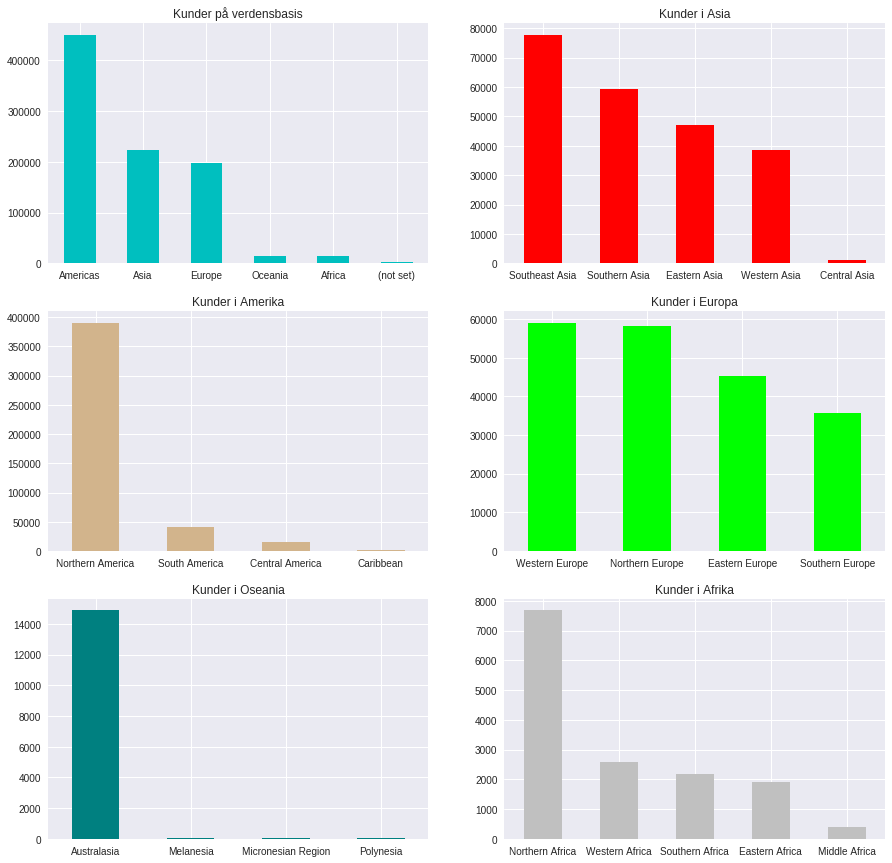

In [0]:
fig, axes = plt.subplots(3,2, figsize=(15,15))
tmp_geo_df["geoNetwork.continent"].value_counts().plot(kind="bar",ax=axes[0][0],title="Kunder på verdensbasis",rot=0,color="c")
tmp_geo_df[tmp_geo_df["geoNetwork.continent"] == "Americas"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][0], title="Kunder i Amerika",rot=0,color="tan")
tmp_geo_df[tmp_geo_df["geoNetwork.continent"] == "Asia"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[0][1], title="Kunder i Asia",rot=0,color="r")
tmp_geo_df[tmp_geo_df["geoNetwork.continent"] == "Europe"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax=axes[1][1],  title="Kunder i Europa",rot=0,color="lime")
tmp_geo_df[tmp_geo_df["geoNetwork.continent"] == "Oceania"]["geoNetwork.subContinent"].value_counts().plot(kind="bar",ax = axes[2][0], title="Kunder i Oseania",rot=0,color="teal")
tmp_geo_df[tmp_geo_df["geoNetwork.continent"] == "Africa"]["geoNetwork.subContinent"].value_counts().plot(kind="bar" , ax=axes[2][1], title="Kunder i Afrika",rot=0,color="silver")

Prosent av kanal grupper brukt: 
Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Name: channelGrouping, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



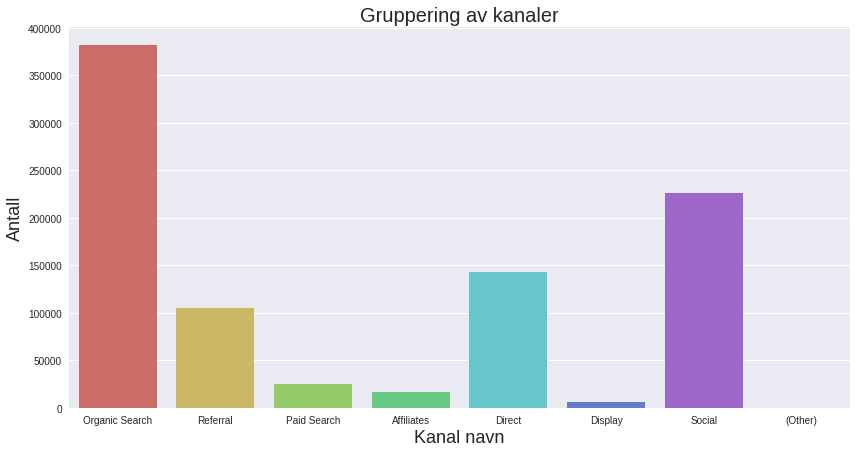

In [0]:
print("Prosent av kanal grupper brukt: ")
print((train_df['channelGrouping'].value_counts()[:5]))

plt.figure(figsize=(14,7))

sns.countplot(train_df["channelGrouping"], palette="hls")
plt.title("Gruppering av kanaler", fontsize=20)
plt.xlabel("Kanal navn", fontsize=18)
plt.ylabel("Antall", fontsize=18)

plt.show()

Grafen over viser oss hvilke kanaler brukerne har benyttet for å komme til GStore.

Datasettet er svært stort, og vi vil derfor rydde opp i datasettet ved å finne kolonner som ikke er unike og derfor ikke vil ha noen effekt på modellene. Disse vil vi seinere fjerne.

In [0]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

Til slutt ser vi på om det er noe data som ikke i testsettet, og som ikke er transactionRevenue.

In [0]:
print("Variabler i treningsettet men ikke i testsett : ", set(train_df.columns).difference(set(test_df.columns)))

Variabler i treningsettet men ikke i testsett :  {'totals.transactionRevenue', 'trafficSource.campaignCode'}


## 4. Forbedre dataen slik at den går bedre med maskinlæringsalgoritmene

Det første vi vil gjøre er å fjerne kolonnene vi fant som ikke er unike. SessionId har heller ingen effekt på dataen og kan derfor også fjernes.

In [0]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

Etter dette ordner vi opp i datasettene våre slik at de ikke inneholder noen NaN-objekter, og konverterer alle integere til float. Deretter konverterer vi alle objektene ved hjelp av labelencoder for å forsikre oss at modellene våre klarer å lese datasettet. 

Vi har deretter valgt å splitte datasettet på dato for teste om dette vil gi et godt resultat.

In [0]:
#fyller tomme variabler med 0
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


#Setter labels på variablene, og konverterer ints til float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

#Splitter datasettet basert på dato med det første, skal forbedres senere 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


Text(0.5,1,'Manglende verdier i kolonner')

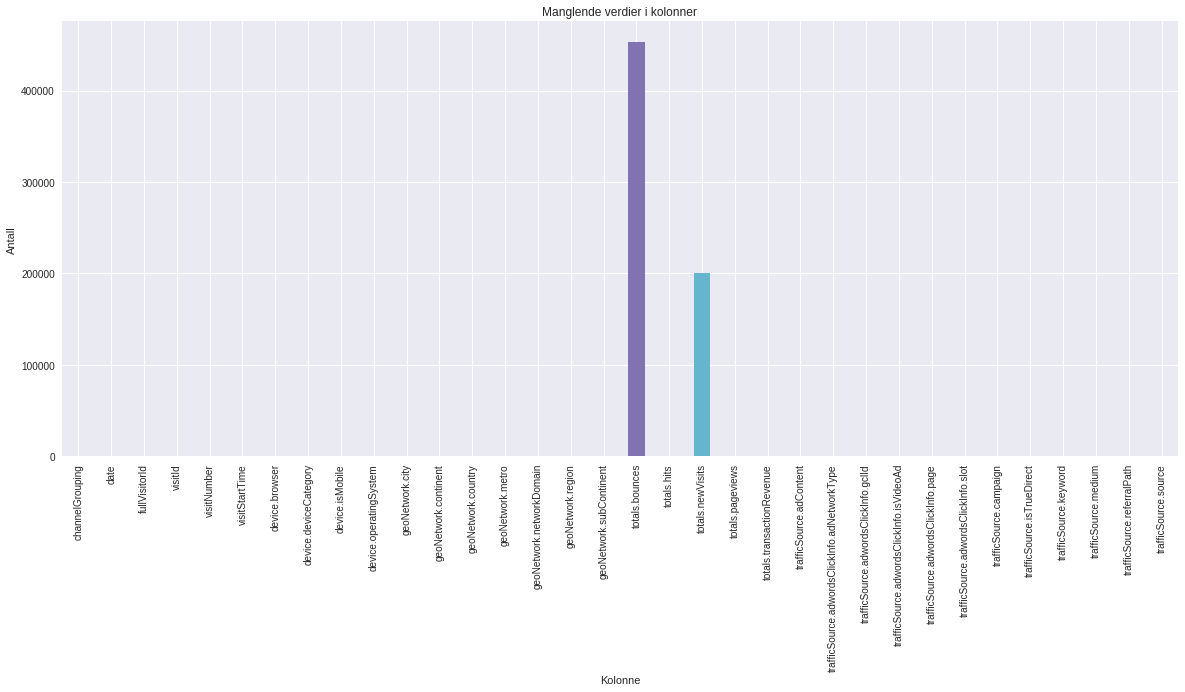

In [0]:
train_df.isnull().sum().plot(kind="bar", figsize = (20,8))
plt.xlabel("Kolonne")
plt.ylabel("Antall")
plt.title("Manglende verdier i kolonner")

Grafen over viser at vi fortsatt mangler en del data på to objekter i datasettet. Bounces vil si at man går rett inn ut og på en nettside, og newvisit vil si at det er en ny bruker på nettsiden.

Her må vi vurdere om vi skal sette alle disse elementene til 0 slik at modellene kan kjøres, og om elementene eventuelt har en invirkning på hverandre.

In [0]:
train_df["totals.bounces"].value_counts()

1.0    450630
Name: totals.bounces, dtype: int64

In [0]:
train_df["totals.newVisits"].value_counts()

1.0    703060
Name: totals.newVisits, dtype: int64

## 5. Gå igjennom ulike modeller og finne den som passer best til vår datasett

### Light Gradient Boosting Machine

På grunn av at datasettet vårt er stort og komplisert bestemmer vi oss for å først prøve å kjøre det gjennom LightGBM. Under definerer vi derfor en metode som kan ta imot datasett og estimere et beløp.


In [0]:
#Egendefinert modell for å kjøre lgbm
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

Ved kjøring av datasettet ser vi at vi til slutt får en verdi på 1.69923. Ikke den beste scoren man kan få, men ikke et dårlig resultat heller.

In [0]:
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.94124
[200]	valid_0's rmse: 1.83509
[300]	valid_0's rmse: 1.77747
[400]	valid_0's rmse: 1.74579
[500]	valid_0's rmse: 1.72725
[600]	valid_0's rmse: 1.71591
[700]	valid_0's rmse: 1.70862
[800]	valid_0's rmse: 1.70414
[900]	valid_0's rmse: 1.70113
[1000]	valid_0's rmse: 1.69923
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.69923


Denne metoden regner ut en score med predicted og revenue, og bruker rmse.

In [0]:
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))


1.726436669922586


LightGBM har en innebygd metode for å vise hvor mye påvirkning hver datakolonne har på transactionRevenue. Med denne informasjonen ser vi at det ikke bare er noen få objekter som påvirker resultatet men litt fra overalt. 

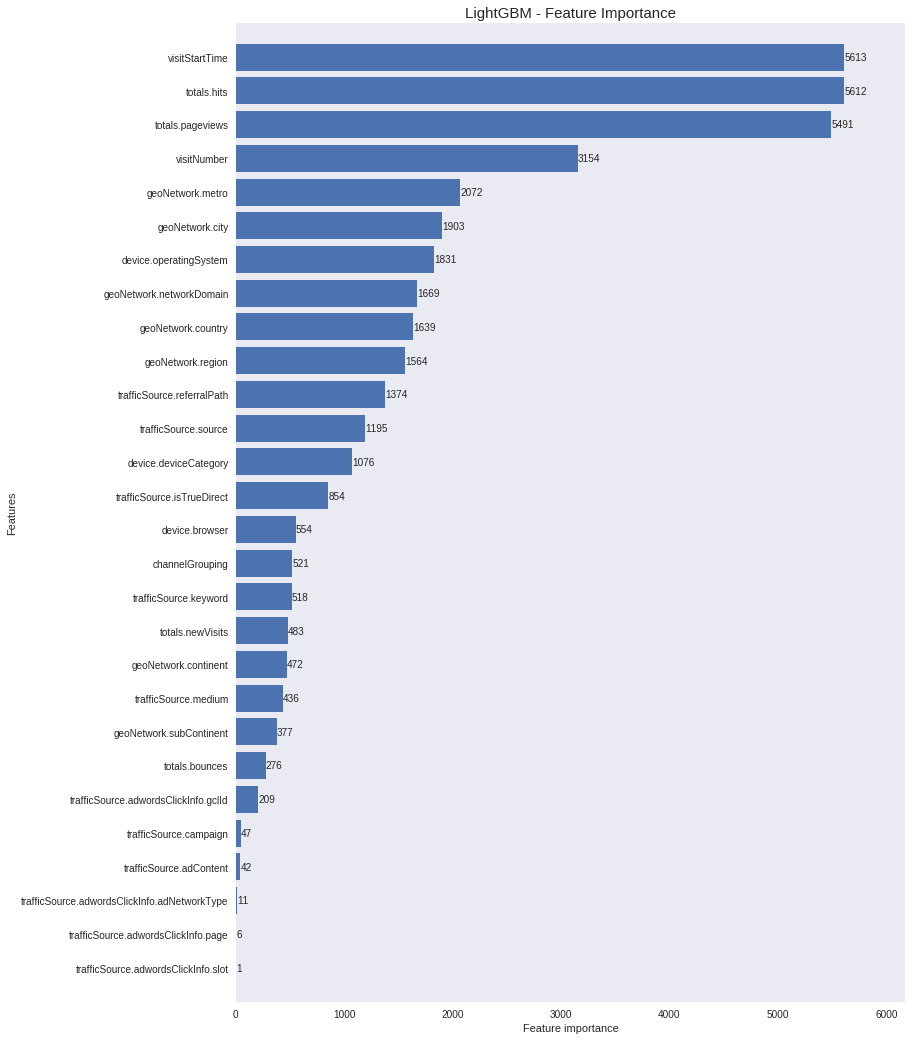

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### XGBoost

Så kjører vi dataen gjennom XGBoost for å se om den vil gi oss bedre resultat.

In [0]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)
  
def run_xgb(X_train, y_train, X_val, y_val, X_test):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print(f"XGB : RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [0]:
%%time
xgb_preds, xgb_model = run_xgb(dev_X, dev_y, val_X, val_y, test_X)

[0]	train-rmse:1.99819	valid-rmse:2.14674
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.78272	valid-rmse:1.93944
[1000]	train-rmse:1.66117	valid-rmse:1.82956
[1500]	train-rmse:1.58843	valid-rmse:1.77189
XGB : RMSE val: 1.74201  - RMSE train: 1.53989
CPU times: user 1h 30min 24s, sys: 2.85 s, total: 1h 30min 27s
Wall time: 46min 27s


Etter år og dager kom vi fram til denne modellen ikke ga noe bedre svar. Etter dette må vi vurdere om det vi har kommet frem til er et godt nok resultat. Og vi kan nå stille oss selv spørsmål som; Hvilken vil bli best ved fintuning? Kan vi splitte dataen på en bedre måte? Var tidssplitting en god metode å starte med?

Denne regner også ut validationscore, men er gjort om slik at den kan bruke XGBoost sin modell:

In [0]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

Vi kan også se på de 5 øverste estimeringene for å se om vi faktisk får tak i tall som ikke er bare tull. 

In [0]:
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.820145
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.048412


### RandomForestRegressor

Konverterer NaN-verdier til 0 slik at RandomizedSearchCV kan kjøres:

In [0]:
from numpy import *
val_X = np.where(np.isnan(val_X), 0, val_X)
val_y = np.where(np.isnan(val_y), 0, val_y)



RandomizedSearchCV tar tilfeldige parametere og tester med RandomForestRegressor bare for å se om det kan brukes.

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor


param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(val_X, val_y)

Som vi kan ser får vi heller ikke noe gode resultater fra RandomForestRegressor.

In [0]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.7569401293770888 {'max_features': 7, 'n_estimators': 180}
1.8163657418618369 {'max_features': 5, 'n_estimators': 15}
1.7739173768038738 {'max_features': 3, 'n_estimators': 72}
1.8014138529374788 {'max_features': 5, 'n_estimators': 21}
1.7586012595751777 {'max_features': 7, 'n_estimators': 122}
1.7740561424116448 {'max_features': 3, 'n_estimators': 75}
1.7727203808691472 {'max_features': 3, 'n_estimators': 88}
1.7671661240990248 {'max_features': 5, 'n_estimators': 100}
1.76910832167973 {'max_features': 3, 'n_estimators': 150}
2.1564655473984162 {'max_features': 5, 'n_estimators': 2}


## 6.Fin-tune modellene og kombinere dem til en god løsning!

### Fintuning av LightGBM ved hjelp av GridSearch

For å finne bedre hyperparametere bruker vi først LightGBM sin dokumentasjon. Vi ønsker at modellen skal få mest mulig accurate resultat uten å bruke for mye ressurser.

In [0]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
lightgbm_reg = lgb.LGBMRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*250=4500 rounds of training 
grid_search = GridSearchCV(lightgbm_reg, param_grid, cv=250,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(val_X, val_y)

GridSearchCV(cv=250, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
grid_search.best_params_


{'max_features': 2, 'n_estimators': 30}

In [0]:
grid_search.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       max_features=2, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=30, n_jobs=-1, num_leaves=31,
       objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

Vi ser her at gridSearch ikke klarer å finne et godt svar med hyperparametere. Vi kan eventuelt gi den lengre tid til å gå igjennom flere muligheter.

In [0]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.9577096230997635 {'max_features': 2, 'n_estimators': 3}
1.7794332747288157 {'max_features': 2, 'n_estimators': 10}
1.7099165897833217 {'max_features': 2, 'n_estimators': 30}
1.9577096230997635 {'max_features': 4, 'n_estimators': 3}
1.7794332747288157 {'max_features': 4, 'n_estimators': 10}
1.7099165897833217 {'max_features': 4, 'n_estimators': 30}
1.9577096230997635 {'max_features': 6, 'n_estimators': 3}
1.7794332747288157 {'max_features': 6, 'n_estimators': 10}
1.7099165897833217 {'max_features': 6, 'n_estimators': 30}
1.9577096230997635 {'max_features': 8, 'n_estimators': 3}
1.7794332747288157 {'max_features': 8, 'n_estimators': 10}
1.7099165897833217 {'max_features': 8, 'n_estimators': 30}
1.9577096230997635 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1.7794332747288157 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
1.9577096230997635 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1.7794332747288157 {'bootstrap': False, 'max_features': 3, 'n

I funksjonen under har vi tatt parameterene fra GridSearch, fjernet de variablene som var satt til default og finetunet litt for å forbedre resultatet:

In [0]:
# egendefinert metode med parametere hentet fra gridsearch
def run_lgb_2(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        'boosting_type': 'gbdt',
        'class_weight': 'None',
        'colsample_bytree': 1.0,
        'importance_type': 'split',
        'learning_rate': 0.05,
        'max_depth' : 15,
        'max_features': 2,
        'min_child_samples': 20,
        'min_child_weight': 0.001,
        'n_jobs': -1,
        'num_leaves': 43,
        'random_state': 42,
        'importance_type': 'split',
        'subsample': 1.0,
        'subsample_for_bin': 200000,
        
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

Og hvorfor ikke splitte dataen opp med train_test_split mens vi er igang for å se om det vil ha en påvirkning i tillegg?

In [0]:
from sklearn.model_selection import train_test_split

train_set_2, test_set_2 = train_test_split(train_df, test_size=0.15, random_state=42)

In [0]:
dev_df_4 = train_set_2
val_df_4 = test_set_2

dev_y_4 = np.log1p(dev_df_4["totals.transactionRevenue"].values)
val_y_4 = np.log1p(val_df_4["totals.transactionRevenue"].values)

dev_X_4 = dev_df_4[cat_cols + num_cols] 
val_X_4 = val_df_4[cat_cols + num_cols] 
test_X_4 = test_df[cat_cols + num_cols]

In [0]:
pred_test_4, model_4, pred_val_4 = run_lgb_2(dev_X_4, dev_y_4, val_X_4, val_y_4, test_X_4)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.61573
[200]	valid_0's rmse: 1.60957
[300]	valid_0's rmse: 1.60857
[400]	valid_0's rmse: 1.60885
Early stopping, best iteration is:
[334]	valid_0's rmse: 1.60773


Som vi kan se over gir dette oss den beste scoren så langt.

Vi kjører funksjonen under igjen for å sjekke om det er noen endringer i hvilke features som har stor påvirkning, men som vi kan se er det minimale endringer:

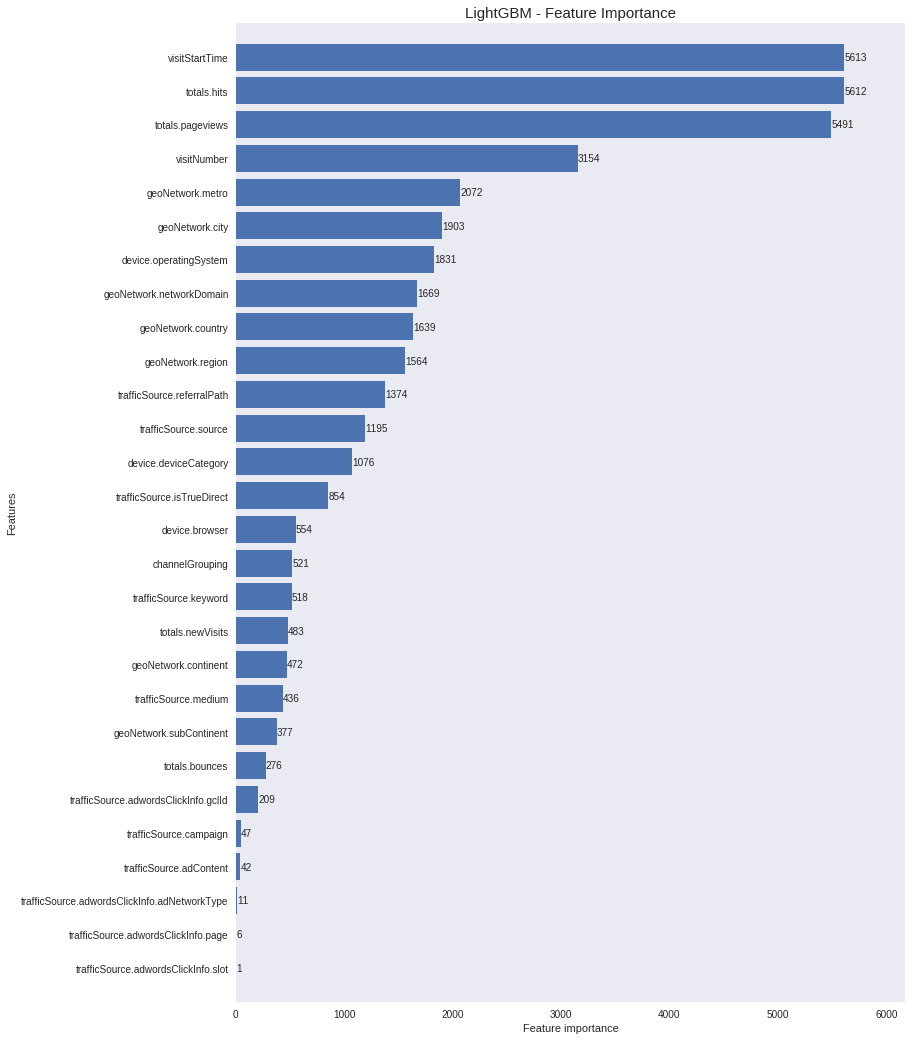

In [0]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [0]:
from sklearn import metrics
pred_val_4[pred_val_4<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df_4["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df_4["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val_4)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.6122801276481271


### Fintuning av LightGBM ved hjelp av RandomizedSearch

Vi prøver å bruke randomizedSearchCV for å forbedre paramterene for LightGBM:

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {
        'n_estimators': randint(low=1, high=400),
        'max_features': randint(low=1, high=12),
    }

lightgbm_reg = lgb.LGBMRegressor(random_state=42)
rnd_search_1 = RandomizedSearchCV(lightgbm_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_1.fit(val_X, val_y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3c09267cc0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3c092674a8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

Her får vi ut de beste parameterene i søket:

In [0]:
rnd_search_1.best_params_


{'max_features': 11, 'n_estimators': 72}

In [0]:
rnd_search_1.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       max_features=11, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=72, n_jobs=-1, num_leaves=31,
       objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [0]:
cvres = rnd_search_1.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.7664651384349899 {'max_features': 7, 'n_estimators': 349}
1.7240148435692353 {'max_features': 11, 'n_estimators': 72}
1.729852979328703 {'max_features': 5, 'n_estimators': 103}
1.746717551822547 {'max_features': 10, 'n_estimators': 215}
1.7268602316559858 {'max_features': 11, 'n_estimators': 88}
1.7293633218955486 {'max_features': 5, 'n_estimators': 100}
1.738305904500432 {'max_features': 8, 'n_estimators': 152}
1.7381701773871616 {'max_features': 3, 'n_estimators': 150}
1.7525653970595882 {'max_features': 5, 'n_estimators': 258}
1.758011861170185 {'max_features': 8, 'n_estimators': 294}


Som vi ser over gir ikke dette oss en bedre score en det vi har fått tidligere.

### Fintuning av XGBoost ved hjelp av RandomizedSearch

Vi prøver også RandomizedSearchCV med XGBoost for å se om vi får bedre parametere:

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {'n_estimators': [1000, 1500, 2000, 2500],
               'max_depth':  [4, 5, 8, -1],
               'num_leaves': [15, 31, 63, 127],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

xgboost_reg = xgb.XGBRegressor(random_state=42)
rnd_search_2 = RandomizedSearchCV(xgboost_reg, param_distributions=param_distribs,
                                n_iter=60, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search_2.fit(val_X, val_y)

In [0]:
rnd_search_2.best_params_


{'colsample_bylevel': 0.5,
 'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3.0,
 'n_estimators': 100,
 'reg_lambda': 100.0,
 'silent': False,
 'subsample': 0.8}

In [0]:
rnd_search_2.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.6, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=3.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=42, reg_alpha=0, reg_lambda=100.0, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.8)

Så plaserer vi resultatet fra RandomizedSearchCV inn i XGBoost for å se om dette gir oss et bedre resultat enn det vi tidligere har fått.

In [0]:
from sklearn.model_selection import train_test_split

train_set_3, test_set_3 = train_test_split(train_df, test_size=0.30, random_state=42)


In [0]:
dev_df_4 = train_set_3
val_df_4 = test_set_3

dev_y_4 = np.log1p(dev_df_4["totals.transactionRevenue"].values)
val_y_4 = np.log1p(val_df_4["totals.transactionRevenue"].values)

dev_X_4 = dev_df_4[cat_cols + num_cols] 
val_X_4 = val_df_4[cat_cols + num_cols] 
test_X_4 = test_df[cat_cols + num_cols] 

In [0]:
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)
  
def run_xgb_2(X_train, y_train, X_val, y_val, X_test):
    params = {'colsample_bylevel': 0.5,
 'colsample_bytree': 0.6,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3.0,
 'n_estimators': 100,
 'reg_lambda': 100.0,
 'silent': False,
 'subsample': 0.8}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
    xgb_val_data = xgb.DMatrix(X_val, y_val)
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=2000, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)
    y_pred_val = model.predict(xgb_val_data, ntree_limit=model.best_ntree_limit)
    y_pred_submit = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print(f"XGB : RMSE val: {rmse(y_val, y_pred_val)}  - RMSE train: {rmse(y_train, y_pred_train)}")
    return y_pred_submit, model

In [0]:
%%time
xgb_preds, xgb_model = run_xgb_2(dev_X_4, dev_y_4, val_X_4, val_y_4, test_X_4)

[0]	train-rmse:1.97563	valid-rmse:1.98153
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:1.59192	valid-rmse:1.6362
[1000]	train-rmse:1.56648	valid-rmse:1.6319
Stopping. Best iteration:
[1105]	train-rmse:1.56187	valid-rmse:1.63172

XGB : RMSE val: 1.63171  - RMSE train: 1.56187
CPU times: user 14min 15s, sys: 1.13 s, total: 14min 16s
Wall time: 7min 34s


Alt i alt kan vi se forbedringsresultat med XGBoost, men ikke bedre enn lightGBM. 

Vi kan også se at XGBoost prioriterer andre objekter enn det LightGBM gjør:

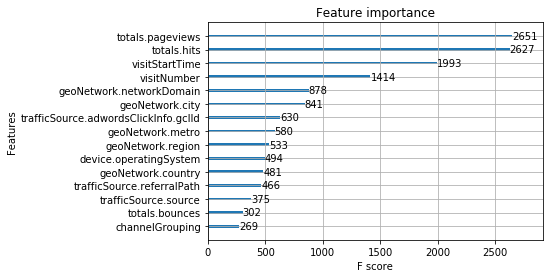

In [0]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgb_model, max_num_features = 15)
pyplot.show()

Under vil vi prøve å shuffle treningsettet opp i to deler basert på shuffle_indices for å se om dette vil påvirke resultatet vi får.

In [0]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(train_df, 0.2)
  

In [0]:
dev_df_2 = train_set
val_df_2 = test_set

dev_y_2 = np.log1p(dev_df_2["totals.transactionRevenue"].values)
val_y_2 = np.log1p(val_df_2["totals.transactionRevenue"].values)

dev_X_2 = dev_df_2[cat_cols + num_cols] 
val_X_2 = val_df_2[cat_cols + num_cols] 
test_X_2 = test_df[cat_cols + num_cols] 


In [0]:
print(len(dev_df), "train +", len(val_df), "test")

765707 train + 137946 test


In [0]:
print(len(dev_df_2), "train +", len(val_df_2), "test")

722923 train + 180730 test


In [0]:
pred_test_2, model_2, pred_val_2 = run_lgb2(dev_X_2, dev_y_2, val_X_2, val_y_2, test_X_2)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.85835
[200]	valid_0's rmse: 1.76406
[300]	valid_0's rmse: 1.71217
[400]	valid_0's rmse: 1.68433
[500]	valid_0's rmse: 1.66689
[600]	valid_0's rmse: 1.6554
[700]	valid_0's rmse: 1.64729
[800]	valid_0's rmse: 1.64118
[900]	valid_0's rmse: 1.63644
[1000]	valid_0's rmse: 1.63348
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.63348


In [0]:
from sklearn import metrics
pred_val_2[pred_val_2<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df_2["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df_2["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val_2)
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.6212690372147571


Vi kan da konkludere med at denne måten for å trene modellen ikke var bedre enn å bare splitte dataen tilfeldig.

Til slutt ser vi på RandomizedSearchCV ved lightGBM for å finne ut om det er nødvendig å prøve å kjøre dataen på denne måten:

In [0]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


param_distribs = {'n_estimators': [250, 500, 750, 1000],
               'max_depth':  [4, 5, 8, -1],
               'num_leaves': [15, 31, 63, 127],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}

lightgbm_reg = lgb.LGBMRegressor(random_state=42)
rnd_search_3 = RandomizedSearchCV(lightgbm_reg, param_distributions=param_distribs,
                                n_iter=20, cv=10, scoring='neg_mean_squared_error', random_state=42)
rnd_search_3.fit(val_X_4, val_y_4)

In [0]:
rnd_search_3.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 5,
 'n_estimators': 250,
 'num_leaves': 63,
 'subsample': 1.0}

In [0]:
rnd_search_3.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       importance_type='split', learning_rate=0.1, max_depth=5,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=250, n_jobs=-1, num_leaves=63, objective=None,
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
cvres = rnd_search_3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.6437059963860565 {'subsample': 0.7, 'num_leaves': 127, 'n_estimators': 250, 'max_depth': 4, 'colsample_bytree': 0.8}
1.6510521704510466 {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 750, 'max_depth': 5, 'colsample_bytree': 0.7}
1.6804243234001222 {'subsample': 0.6, 'num_leaves': 127, 'n_estimators': 1000, 'max_depth': 8, 'colsample_bytree': 0.7}
1.6468983931290104 {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 500, 'max_depth': 4, 'colsample_bytree': 0.6}
1.653254180656184 {'subsample': 0.8, 'num_leaves': 63, 'n_estimators': 750, 'max_depth': 5, 'colsample_bytree': 0.8}
1.642313844017631 {'subsample': 1.0, 'num_leaves': 63, 'n_estimators': 250, 'max_depth': 5, 'colsample_bytree': 0.8}
1.6804243234001222 {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 1000, 'max_depth': 8, 'colsample_bytree': 0.7}
1.7224939323827513 {'subsample': 0.8, 'num_leaves': 127, 'n_estimators': 500, 'max_depth': -1, 'colsample_bytree': 0.8}
1.6445901155894544 {'subsample': 0.6, 'num_leaves'

Ut ifra mean_scoren som vi kommer fram til over, beslutter vi å forholde oss til det tidligere resultatet.

## 7. Presentere resultatet

I løpet av dette prosjektet har vi satt sammen en maskinlæringsalgoritme som kan estimere et beløp for den neste brukeren som besøker GStore. Vi har brukt tre ulike modeller for å estimere omsetningen; RandomForestRegressor, LightGBM og XGBoost. Det beste resultatet fikk vi ved å bruke LightGBM med hyperparametere som er finetunet ved hjelp av GridSearchCV. Resultatet ble **1.6122801276481271**, hvor XGBoost lå bak med 2. RandomForestRegression-metoden vår kom aldri fram til et resultat vi var fornøyde med, og derfor droppet vi den tidlig. Vi kunne fintunet modellen til å fungere med datasettet vårt, men vi valgte å prioritere LightGBM og XGBoost da dette ga oss et mer ønskelig resultat. 

Som vi har sett på feature importance ligger visitStartTime ganske høyt. Grunnen til dette kan være at ettersom omsetningen øker med tid vil det være en korrelasjon der. En annen grunn kan være at dette har med kundenes kjøpevaner å gjøre. Som oftest vil kunder kjøpe varer i løpet av ettermiddagen, og derfor er dette linket til omsetningen. 

For å forbedre scoren kunne vi ha fintunet hyperparamterene enda mer og eventuelt ryddet litt mer i datasettet, men med tanke på vår kunnskap og begrensede ressurser sier vi oss fornøyd med det resultatet vi har fått. Den kraftigste pcen prosjektet ble kjørt på var:
* Macbook Pro(15-inch, 2017)
* Processor - 2,8 GHz Intel Core i7
* Memory - 16 GB
* Graphics - Radeon Pro 555 2048 MB


## 8. Publisere, observere og vedlikeholde systemet.

Etter vi har kommet fram til svaret vårt kan Google Cloud (arrangørene av konkurransen) vurdere å bruke dataen vår i etterkant til sine nettsider. Ettersom prosjektet vårt ikke ligger i nærheten av de beste resultatene vil prosjektet mest sannsynlig ikke bli brukt til mer enn denne innleveringen. Konkurransen er open source så om andre bestemmer seg for å benytte koden vår til et framtidig prosjekt så har vi i hvert fall bidratt til noe. Om prosjektet skulle brukes videre må man ha revurdert hvordan prosjektet er satt opp, for eksempel ved å ta hensyn til ny data som kommer inn og vedlikeholde modellene slik at de plutselig ikke utsettes for overfitting eller underfitting.

Alt i alt så har dette vært et lærerikt prosjekt hvor vi har fått mye innsikt i hvordan maskinlæring fungerer. 


###Extra

En Kaggle-deltaker fant et loophole som ga 0 i score, noe som gjorde at de måtte legge ut nye train- og test-sett. Her er linjen som gjorde dette mulig:

In [0]:
__import__('pandas').read_csv('../input/test_v2.csv', usecols=[4,8], dtype={'fullVisitorId': 'str'}, converters={'totals': lambda t: float(dict(eval(t))['transactionRevenue']) if 'transactionRevenue' in t else 0}).groupby(['fullVisitorId'])['totals'].sum().to_frame(name='PredictedLogRevenue').apply(__import__('numpy').log1p).to_csv('sub.csv')

#Kilder
* "Hands on machine learning with Sckit learn and Tensorflow" - Av Aurélien Géron, 2017
* https://www.kaggle.com/c/ga-customer-revenue-prediction
* https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
* https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
* https://www.kaggle.com/kabure/exploring-the-consumer-patterns-ml-pipeline
* https://www.kaggle.com/artgor/eda-on-basic-data-and-lgb-in-progress
* https://www.kaggle.com/paulorzp/perfect-score-one-line-without-semicolon
* https://www.kaggle.com/smasar/tutorial-preprocessing-processing-evaluation/notebook
* https://www.kaggle.com/smasar/tutorial-preprocessing-processing-evaluation
* https://www.kaggle.com/julian3833/2-quick-study-lgbm-xgb-and-catboost-lb-1-66
* https://stackoverflow.com
* https://github.com/alu042/DAT158ML
* https://github.com/HVL-ML/prosjekt-1-end-to-end-maskinlaeringsprosjekt-h181182
* https://xgboost.readthedocs.io/en/latest/
* https://lightgbm.readthedocs.io
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
